<a href="https://colab.research.google.com/github/KaroAntonio/climate-social-analysis/blob/main/notebooks/Climate_Conversation_Topic_Modelling_Model_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Climate Conversation Topic Modelling - Model Evaluation

Overarching Data Problem:   
*What Topics can be extracted from climate tweets and what is the measurable relevance of those topics.*

We've performed Data Wrangling, Exploration, Preprocessin, and Feature Engineering. Our next step is to experiment with several models for clustering and to evaluate the performance of those models.

LDA is a classic topic modelling alg that is a good baseline to compare to. However, it does not make use of the the token / sentance embeddings, so we may be able to improve on it.

We will explore algs that determine K automatically first in order to inform K chosen for those algs that require K as an input.

### Models
We explore the following clustering/topic modelling algs:
* Greedy Co-occurance Clustering
* HDBSCAN (2013)
  * In: Vecs
  * Out: K, Clusters
* Agglomerative Clustering (1980s)
  * In: Vectors
  * Out: Cluster Heirarchy
* Mean Shift (2002)
  * In: Vecs
  * Out: K, Clusters
* LDA (2003)
  * In: Tokens, K
  * Out: Topic Clusters
* Brown (1992)
  * In: Tokens
  * Out: Cluster Heirarchy
* K-MEANS? (1967)
  * In: Vecs, K
  * Out: Clusters

### Metrics
What are the characteristics of a 'good topic'?
* Silhouette Score  
* Variance Ratio Criterion
* Top Tokens in agreement vs Most common tokens in disagreement
  * I propose this as:
* Subjective Coherece
  * Do the grouped clusters look right?
* Subjective Cluster Keyword Relevence
  * Do the Cluster Topic Keywords look right?

In [ ]:
! pip install hdbscan

In [ ]:
! pip install umap-learn

In [ ]:
! pip install sentence-transformers

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from nltk import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cut_tree
import matplotlib.pyplot as plt
import umap
from sentence_transformers import SentenceTransformer


# models
import hdbscan
from sklearn.cluster import Birch
from sklearn.cluster import AgglomerativeClustering

drive.mount('/content/drive')

In [7]:
# Data paths
DRIVE_DIR = "/content/drive/MyDrive/Climate Social Analysis/data/"
PREPROCESSED_TOKENS_PATH = f"{DRIVE_DIR}topic_modelling_preprocessed_tokens_1m.csv"
TWEET_EMBEDDINGS_PATH = f"{DRIVE_DIR}topic_modelling_tweet_embeddings_1m.csv"
TWEET_PCA_FEATURES_PATH = f"{DRIVE_DIR}topic_modelling_tweet_pca_features_1m.csv"
WORD_VECTOR_SUBSET_PATH = f"{DRIVE_DIR}topic_modelling_word_vector_subset.csv"

In [8]:
# Load Data
# Load Tweet Embeddings
tweet_embeddings_df = pd.read_csv(TWEET_EMBEDDINGS_PATH, index_col='id')
tokens_str_df = pd.read_csv(PREPROCESSED_TOKENS_PATH, index_col='id')
#tweet_pca_features_df = pd.read_csv(TWEET_PCA_FEATURES_PATH, index_col='id')
word_vector_subset_df = pd.read_csv(WORD_VECTOR_SUBSET_PATH)

In [107]:
# Prep Token Data
tokens_str_df = tokens_str_df.loc[tweet_embeddings_df.index]

word_vector_subset_df = pd.read_csv(WORD_VECTOR_SUBSET_PATH)
word_vector_subset_df.set_index('Unnamed: 0', inplace=True)

# This is a lookup of the vocab we're working with
vocab = word_vector_subset_df.index
vocab_set = set(vocab)
vocab = [str(e) for e in list(vocab_set)] #
vocab_idx_lookup = {vocab[i]:i for i in range(len(vocab))}
print(f"Vocab size: {len(vocab)}")

# Unpack the token lists
tokens_sr = tokens_str_df.apply(lambda x: x.str.split())['processed_tokens_str']

# Retain only tokens in vocab
tokens_sr = tokens_sr.apply(lambda ts: [t for t in ts if t in vocab_set])

# Prep a token dataset without the climate key stopwords
climate_stop_words = ['climate', 'change','global','warming']
tokens_noccgw_sr = tokens_sr.apply(lambda ts: [t for t in ts if t not in climate_stop_words])

Vocab size: 28862


# Metrics

We define the metrics before the model exploration so that we have consistent metrics to evulate all models by.

In [242]:
def sort_topics_by_size(token_topics_sr):
  group_counts_sr = token_topics_sr.groupby(token_topics_sr).size()
  # Use 0-based index for topics
  group_counts_sr = group_counts_sr.sort_index().reset_index(drop=True)
  sorted_groups_sr = group_counts_sr.sort_values(ascending=False)
  return sorted_groups_sr

def left_align(df: pd.DataFrame):
    left_aligned_df = df.style.set_properties(**{'text-align': 'left'})
    left_aligned_df = left_aligned_df.set_table_styles(
        [dict(selector='th', props=[('text-align', 'left')])]
    )
    return left_aligned_df

def get_topic_repr_df(token_topics_sr, topic_token_score, n_rows = 30, n_cols=15):
  # build a representation of all topics to visually inspect
  # each col is a topic ordered in descending order of size
  # each row is the top tokens in that topic, ordered by some metric
  # token is vocab idx of token
  # topic is topic idx in original modelling
  # topic_token_score['token']['topic'] = score

  # TODO: Sort cols by topic size

  def format_token_score(token_idx, score):
    token = vocab[token_idx]
    return f'{score:.3f} {token}'

  formatted_topic_tokens = {}
  for topic_idx in range(topic_token_score.shape[1]):
    sorted_topic_tokens_sr = pd.Series(topic_token_score[:, topic_idx]).sort_values(ascending=False)[:n_rows]
    formatted_topic = [format_token_score(token_idx, score) for token_idx, score in  sorted_topic_tokens_sr.items()]
    formatted_topic_sr = pd.Series(formatted_topic)
    formatted_topic_tokens[topic_idx] = formatted_topic_sr

  # Get topic sizes to sort topic cols by
  topic_sizes = sort_topics_by_size(token_topics_sr)
  sorted_topic_idxs = topic_sizes.index
  # Build topic repr df
  topic_repr_df = pd.DataFrame(formatted_topic_tokens, columns=sorted_topic_idxs)
  # Add in topic sizes as row
  topic_repr_df = pd.concat([topic_sizes.to_frame().T, topic_repr_df], ignore_index=True).rename(index={0: 'size'})
  # Select n_cols
  topic_repr_df = topic_repr_df[topic_repr_df.columns[:n_cols]]

  return topic_repr_df

## Model Evaluation

In [270]:
# Sample the dataset for testing
N_sample = 100000
sample_df = tweet_embeddings_df.sample(N_sample)
X = sample_df.values

In [77]:
# for each model, store results under model name
# model_results['model_name']['topic_labels'] = pd.Series of topic labels as 'topic'
model_results = {}

### UMAP & HDBSCAN & TF-IDF

TODO: Attempt SentenceTransformer (Distilber)

IDEA: Explore Using closest Token Vecs to lookup topic labels

Cluster with UMAP and HDBSCAN

In [ ]:
%env HF_TOKEN={ INSERT HF SECRET }

In [16]:
# Prep data sample
tokens_noccgw_str_sr = tokens_noccgw_sr.apply(lambda ts: ' '.join(ts))

# Train Sentence level tweet embeddings
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(tokens_noccgw_str_sr.values, show_progress_bar=True)

Batches:   0%|          | 0/31247 [00:00<?, ?it/s]

In [19]:
sentence_embeddings_df = pd.DataFrame(embeddings, index=tokens_noccgw_str_sr.index)

In [32]:
# Sample the dataset for testing
N_sample = 100000
sample_df = sentence_embeddings_df.sample(N_sample)
X = sample_df.values

In [34]:
# UMAP is an effective Dimensionality reducing alg that can be used to reduce dims
# for clustering and visualization puproses
umap_embeddings = umap.UMAP(n_neighbors=15,
                            n_components=8,
                            metric='cosine').fit_transform(X)

In [52]:
cluster = hdbscan.HDBSCAN(min_cluster_size=50,
                          # Default is min_samples=15, setting it lower seems to increase the cluster coverage
                          min_samples=1,
                          metric='euclidean',
                          cluster_selection_method='eom').fit(umap_embeddings)

In [245]:
# Visualize Clusters as reduced by UMAP
# Prepare data (use og data to reduce to avoid umap artifact amplification)
def display_labels_umap(X, labels):
  umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(X)
  result = pd.DataFrame(umap_data, columns=['x', 'y'])
  result['labels'] = labels

  # Visualize clusters
  fig, ax = plt.subplots(figsize=(20, 10))
  outliers = result.loc[result.labels == -1, :]
  clustered = result.loc[result.labels != -1, :]
  plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
  plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
  plt.colorbar()

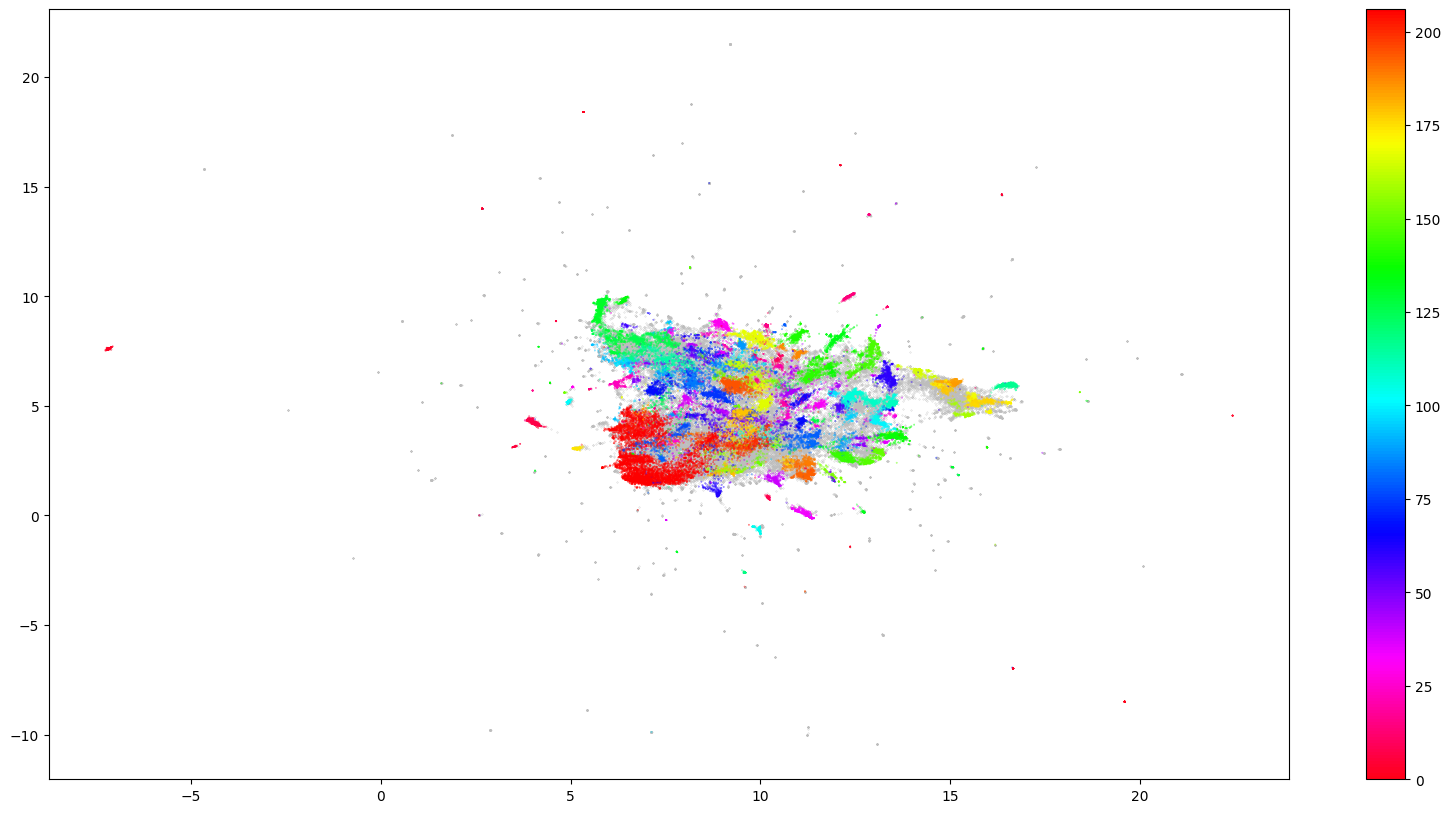

In [246]:
display_labels_umap(X, cluster.labels_)

In [253]:
# Use TF-IDF
sample_tokens_str_df = pd.DataFrame({'token_str':tokens_noccgw_str_sr[sample_df.index]})
sample_tokens_str_df['topic'] = cluster.labels_
# combine the values of all the tweet strs for each group
tweets_per_topic = sample_tokens_str_df.groupby(['topic'], as_index = False).agg({'token_str': ' '.join})
tweets_per_topic.describe() # We have 99 topics, a bit much really

,topic
count,208.000000
mean,102.500000
std,60.188592
min,-1.000000
25%,50.750000
50%,102.500000
75%,154.250000
max,206.000000


In [254]:
def c_tf_idf(topic_tweet_strs, total_tweets):
  count_vec = CountVectorizer().fit(topic_tweet_strs)
  t = count_vec.transform(topic_tweet_strs).toarray()
  w = t.sum(axis=1)
  tf = np.divide(t.T, w)
  sum_t = t.sum(axis=0)
  idf = np.log(np.divide(total_tweets, sum_t)).reshape(-1, 1)
  tf_idf = np.multiply(tf, idf)
  return tf_idf, count_vec

tf_idf, count_vec = c_tf_idf(tweets_per_topic.token_str.values, total_tweets=N_sample)

In [255]:
def extract_top_n_words_per_topic(tf_idf, count_vec, docs_per_topic, n=20):
    words = count_vec.get_feature_names_out()
    labels = list(docs_per_topic.topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['topic'])
                     .token_str
                     .count()
                     .reset_index()
                     .rename({"topic": "topic", "token_str": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count_vec, tweets_per_topic, n=20)
# These topics are a bit too smol
topic_sizes = extract_topic_sizes(sample_tokens_str_df);
print(f'N Topics: {len(topic_sizes)}')
topic_sizes.head(10)

N Topics: 208


,topic,Size
0,-1,54241
207,206,5869
132,131,1265
195,194,1035
3,2,952
117,116,951
180,179,847
169,168,779
62,61,773
127,126,765


In [ ]:
# We have 200 topics, we'd like to get closer to 20 or 30

# ISSUE: Defined topics are being merged with the 'outlier' topic
# TODO: Do not consider the 'outlier' topic as a merging candidate
# Perform itereative cluster merging by tf-idf cosine dist
# Reduce N topics down to 30

# remove outlier topic for merging process
outlier_topic = top_n_words[-1]
top_n_words.pop(-1)

while len(top_n_words) > 30:
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = sample_tokens_str_df.groupby(['topic']).count().sort_values("token_str", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    sample_tokens_str_df.loc[sample_tokens_str_df.topic == topic_to_merge, "topic"] = topic_to_merge_into
    old_topics = sample_tokens_str_df.sort_values("topic").topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    sample_tokens_str_df.topic = sample_tokens_str_df.topic.map(map_topics)
    docs_per_topic = sample_tokens_str_df.groupby(['topic'], as_index = False).agg({'token_str': ' '.join})

    # Calculate new topic words
    tf_idf, count = c_tf_idf(docs_per_topic.token_str.values, N_sample)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

# add outlier topic back in
top_n_words[-1] = outlier_topic
topic_sizes = extract_topic_sizes(sample_tokens_str_df);
topic_sizes.head(10)

In [ ]:
# Build topic_token_tfidf_score
# TODO: Generalize this for use. by all models
# a lookup mat of rows=tokens , cols=topics
topic_token_tfidf_score = np.zeros((len(vocab), len(top_n_words)))
for topic_idx, token_scores in enumerate(top_n_words.values()):
  for token, tf_idf_score in token_scores:
    topic_token_tfidf_score[vocab_idx_lookup[token], topic_idx] = tf_idf_score

In [ ]:
# Clean up our modelled topic data
token_topics_sr = sample_tokens_str_df.topic
model_results['str_embedding_umap_hdbscan'] = {}
model_results['str_embedding_umap_hdbscan']['topics'] = token_topics_sr

In [ ]:
# Inspect the topics Produced by 'str_embedding_umap_hdbscan' by tf-idf
left_align(get_topic_repr_df(token_topics_sr, topic_token_tfidf_score, 15, 10))

In [ ]:
# Plot Final Clusters
display_labels_umap(X, token_topics_sr.values)

### Agglomerative Heirarchical Clustering

In [ ]:
# Fit AgglomerativeClustering
# 10K => 12s

# Instantiate the AgglomerativeClustering object without specifying the number of clusters
agglomerative = AgglomerativeClustering(linkage='ward')

# Fit the model to the data
agglomerative.fit(X)

# Retrieve the cluster labels for each data point
ag_cluster_labels = agglomerative.labels_

In [ ]:
# Fit HDBSCAN
# 10k => 1min
# 100k => Cancelled after 25mins

# Single thread implementation
hdbscan_model = hdbscan.HDBSCAN()

hdbscan_model.fit(X)

hd_cluster_labels = hdbscan_model.labels_

In [ ]:
# Fit BIRCH
# 10k => 3s

birch = Birch(threshold=0.15)

birch.fit(X)

# Predict cluster labels
bi_cluster_labels = birch.predict(X)

In [ ]:
# Evaluate clusterings
# We want to evaluate the clusterings consistently
# TODO: implement as func

n_clusters = len(np.unique(cluster_labels))
silhouette_avg = silhouette_score(X, cluster_labels)
calinski_harabasz_index = calinski_harabasz_score(X, cluster_labels)
print(f'N: {N}, n_clusters: {n_clusters}, silhouette_avg: {silhouette_avg}, calinski_harabasz_index: {calinski_harabasz_index}')


N: 10000, n_clusters: 2, silhouette_avg: 0.08139429882542604, calinski_harabasz_index: 699.7204742200818


In [ ]:
def create_tree_from_linkage(X, to_merge):
    clusters = {}
    for i, merge in enumerate(to_merge):
        if merge[0] <= len(to_merge):
            # if it is an original point, store idx
            a = int(merge[0]) - 1
        else:
            # other wise read the cluster that has been created
            a = clusters[int(merge[0])]
        if merge[1] <= len(to_merge):
            # Handle OG point
            b = int(merge[1]) - 1
        else:
            b = clusters[int(merge[1])]
        # the clusters are 1-indexed by scipy ugh
        clusters[1 + i + len(to_merge)] = {
            'children' : [a, b]
        }
    return clusters

def build_cluster_node_lookup(lm):
  # given the linkage_matrix lm
  # build a lookup dict where as {{node_id}:{child_id_list}}
  # where:
  # node_id is a cluster id
  # child_id_list is a list of either cluster ids or ids from the original data
  lookup = {}
  for i, lm_row in enumerate(lm):
    sbc1_idx, sbc2_idx, dist, n_x = lm_row

    # If the subcluster index is one of the OG datapoints, shift index
    cid1 = int(sbc1_idx - 1 if sbc1_idx <= len(lm) else sbc1_idx)
    cid2 = int(sbc2_idx - 1 if sbc2_idx <= len(lm) else sbc2_idx)

    cluster_node_idx = 1 + i +len(lm)
    lookup[cluster_node_idx] = [cid1, cid2]
  return lookup


In [ ]:
# Retrieve the linkage matrix
# This contains the tree graph we need for herirachical cluster labels
# linkage_matrix.shape = 9999, 4
# each row represents a clustering,
# for cluster i , linkage_matrix[i] =
# [subcluster_idx1, subcluster_idx2, dist, n_x]
# where n_x is N(x) from X in the cluster
linkage_matrix = linkage(X, method='ward')

In [ ]:
# Check that the last element is the top level,
# it is since it has all 10k elements
n_x = linkage_matrix[-1][3]
print(f'Number of elements in cluster: {n_x}')

Number of elements in cluster: 10000.0


In [ ]:
cnl = build_cluster_node_lookup(linkage_matrix)

In [193]:
# WE WANT the FreqDist of tokens of a particular cluster node in the heirarchy
# to get there, we
# 1. build a lookup map from eidx > tweet id (tids) (from tweet_embeddings_df)
# 2. build a lookup of tids for each node in the clustering
# 3. then for a particular node we can build a BOW of all tweets in that cluster
# 4. then we can get the freq dist for that BOW

def convert_to_cid(cidx, N):
  # scipy's linkage_matrix uses a diff idx within the matrix for each cluster
  return 1 + cidx + N

def build_eidxs_lookup(lm):
  # Build a lookup map of cluster_id (cid) => list of embeddings idxs (eidx) in that cluster
  eidx_lookup = {}
  for i, lm_row in enumerate(lm):
    sbc1_idx, sbc2_idx, dist, n_x = lm_row
    eidxs = []
    for sub_idx in [int(sbc1_idx), int(sbc2_idx)]:
      if sub_idx <= len(lm):
        eidxs.append(sub_idx - 1)
      else:
        sub_eidxs = eidx_lookup[sub_idx]
        eidxs.extend(sub_eidxs)

    eidx_lookup[convert_to_cid(i, len(lm))] = eidxs
  return eidx_lookup

def build_bow_from_tids(tids):
  # Given a list of tids
  # build a list of all tokens for those tids
  bow = []
  for tid in tids:
    tokens = tokens_sr.loc[tid]
    bow.extend(tokens)
  return bow

def build_freqdist_for_cluster(cid):
  tids = cid_tids_lookup[cid]
  cluster_bow = build_bow_from_tids(cid_tids_lookup[cid])
  cluster_freqdist = FreqDist(cluster_bow)
  return cluster_freqdist

# 1. build a lookup map from eidx > tweet id (tids) (from tweet_embeddings_df)
cid_eidxs_lookup = build_eidxs_lookup(linkage_matrix)

# 2. build a lookup of tids for each node in the clustering
eidx_to_tid_lookup = tweet_embeddings_df.index.to_list()
# map eidxs to tids
cid_tids_lookup = {}
for cid, eidxs in cid_eidxs_lookup.items():
  tids = [eidx_to_tid_lookup[eidx] for eidx in eidxs]
  cid_tids_lookup[cid] = tids

top_cluster_idx = len(linkage_matrix)-1
top_cluster_freqs = build_freqdist_for_cluster(convert_to_cid(top_cluster_idx, len(linkage_matrix)))
# This looks correct , there's
top_cluster_freqs.most_common(20)

[('climate', 14494),
 ('change', 14325),
 ('global', 6868),
 ('warming', 6530),
 ('action', 1049),
 ('u', 931),
 ('world', 812),
 ('ha', 769),
 ('people', 763),
 ('say', 733),
 ('new', 733),
 ('like', 676),
 ('need', 661),
 ('year', 635),
 ('one', 609),
 ('environment', 608),
 ('trump', 592),
 ('time', 572),
 ('science', 571),
 ('energy', 569)]

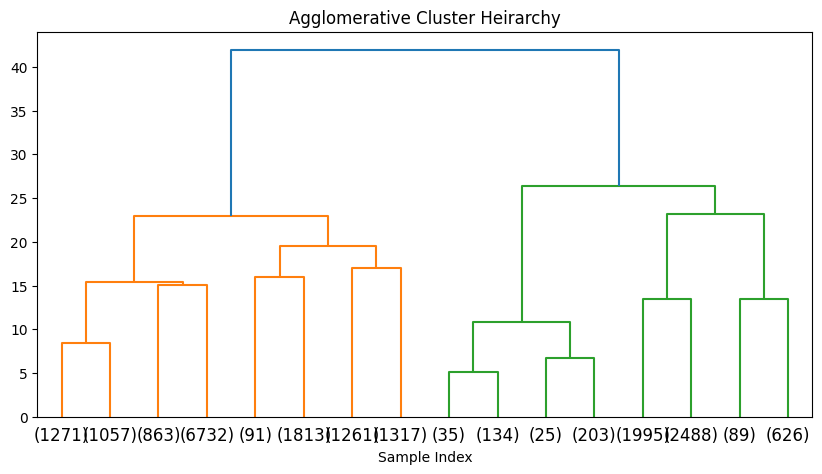

In [194]:
# Plot the dendrogram of the top N clusters of the linkage matrix
# This is a hierarchical clustering
n_top_levels = 3
plt.figure(figsize=(10, 5))
truncated = dendrogram(linkage_matrix, truncate_mode='level', p=n_top_levels)
plt.title('Agglomerative Cluster Heirarchy')
plt.xlabel('Sample Index')
#plt.ylabel('Distance')
plt.show()

In [192]:
# The idxs given in the cluster heriarchy are not what we want,
# We want the ids of the clusters that are the leaves of this
# truncated tree
# so let's cut the tree and inspect it
print(f'Leaves at lvl {n_top_levels}: {len(truncated["leaves"])}')

lvl_cluster_idx = truncated['leaves'][1]
print(lvl_cluster_idx)
top_cluster_freqs = build_freqdist_for_cluster(lvl_cluster_idx)
# This looks correct
top_cluster_freqs.most_common(20)

Leaves at lvl 3: 16
39961
1057


[('climate', 765),
 ('change', 753),
 ('global', 369),
 ('warming', 351),
 ('people', 59),
 ('action', 58),
 ('u', 55),
 ('need', 49),
 ('new', 46),
 ('world', 37),
 ('ha', 36),
 ('energy', 36),
 ('one', 36),
 ('environment', 35),
 ('say', 35),
 ('like', 34),
 ('think', 33),
 ('know', 33),
 ('help', 31),
 ('impact', 31)]

In [199]:
# Let's inspect all the 'clusters' at each level of the Heirarchy
# ISSUE: The topics seem to have very similiar proportions of all of the keywords,
# this is not helpful! It means the clusters have very similiar
print(f'Clusters at Lvl {n_top_levels}')
for cluster_id in truncated['leaves']:
  n_tweets_in_cluster = len(cid_tids_lookup[cluster_id])
  print(f'Cluster {cluster_id} - N={n_tweets_in_cluster}')
  cid_tids_lookup[cluster_id]
  top_20 = build_freqdist_for_cluster(cluster_id).most_common(20)
  formatted_top_20 = ', '.join([f'{t[0]}:{t[1]/n_tweets_in_cluster}' for t in top_20])
  print(f'Top 20: {formatted_top_20}')

Clusters at Lvl 3
Cluster 39919 - N=1271
Top 20: climate:0.7269866247049567, change:0.7199055861526357, global:0.33988985051140835, warming:0.31943351691581434, action:0.058221872541306056, world:0.05428796223446106, u:0.04720692368214005, people:0.046420141620771044, like:0.041699449252557044, one:0.03619197482297404, say:0.03540519276160504, ha:0.03540519276160504, new:0.03461841070023604, science:0.03383162863886703, time:0.03147128245476003, need:0.02989771833202203, scientist:0.02832415420928403, environment:0.02753737214791503, right:0.02675059008654603, think:0.02675059008654603
Cluster 39961 - N=1057
Top 20: climate:0.7237464522232734, change:0.7123935666982024, global:0.3491012298959319, warming:0.33207190160832545, people:0.05581835383159887, action:0.05487228003784295, u:0.05203405865657521, need:0.046357615894039736, new:0.043519394512771994, world:0.03500473036896878, ha:0.03405865657521287, energy:0.03405865657521287, one:0.03405865657521287, environment:0.033112582781456